# Assignment_1_Data_Analysis

This notebook implements the procedures from the paper "Balanced Risk Set Matching" by Yunfei Paul Li, Kathleen J. Propert, and Paul R. Rosenbaum.

The implementation follows these key steps:
1. Synthesizing Experimental Data
2. Risk Set Matching
3. Balance Checking
4. Sensitivity Analysis
5. Outcome Analysis

## Contributors

Samuel Bonghanoy & Christian de Jesus

## Project Setup

We'll use the following libraries:

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.spatial.distance import mahalanobis
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler

## Synthesizing Experimental Data

Since we do not have access to the original data used in the study, we'll need to generate our own. This data mimics the format of the data points used to perform the methodology of the paper.

In [43]:
# Set random seed for reproducibility
np.random.seed(42)
n_samples = 400  # Total patients

# Simulating baseline symptoms (Pain, Urgency, Frequency) on a scale of 0-9
baseline_symptoms = np.random.randint(0, 10, size=(n_samples, 3))

# Generate treatment time (for those treated) and ensure it happens after study entry
enrollment_time = np.random.randint(0, 12, size=n_samples)  # Patients enter study at random times (0-12 months)
treatment_time = enrollment_time + np.random.randint(3, 24, size=n_samples)  # Treatment happens after enrollment

# Convert treatment_time to float to allow np.inf
treatment_time = treatment_time.astype(float)

# Random assignment of treated/not-treated (50% treated, 50% untreated)
is_treated = np.random.choice([0, 1], size=n_samples)

# Patients who are not treated should not have a treatment time
treatment_time[is_treated == 0] = np.inf  # Mark untreated patients as censored

# Simulate post-treatment symptoms by modifying baseline scores
# Symptoms may increase or decrease slightly due to treatment
treatment_symptoms = baseline_symptoms + np.random.randint(-2, 3, size=(n_samples, 3))
treatment_symptoms = np.clip(treatment_symptoms, 0, 9)  # Ensure symptoms stay in valid range

# Additional patient covariates for balancing
age = np.random.randint(20, 80, size=n_samples)  # Age between 20 and 80
gender = np.random.choice([0, 1], size=n_samples)  # 0 = Female, 1 = Male

# Creating DataFrame
data = pd.DataFrame({
    'ID': range(n_samples),
    'Age': age,
    'Gender': gender,
    'Enrollment_Time': enrollment_time,
    'Treatment_Time': treatment_time,
    'Treated': is_treated,
    'Pain_Baseline': baseline_symptoms[:, 0],
    'Urgency_Baseline': baseline_symptoms[:, 1],
    'Frequency_Baseline': baseline_symptoms[:, 2],
    'Pain_Treatment': treatment_symptoms[:, 0],
    'Urgency_Treatment': treatment_symptoms[:, 1],
    'Frequency_Treatment': treatment_symptoms[:, 2],
})

# Simulating follow-up symptoms at 3 and 6 months
pain_3_months = treatment_symptoms[:, 0] + np.random.randint(-2, 3, size=n_samples)
urgency_3_months = treatment_symptoms[:, 1] + np.random.randint(-2, 3, size=n_samples)
frequency_3_months = treatment_symptoms[:, 2] + np.random.randint(-2, 3, size=n_samples)

pain_6_months = pain_3_months + np.random.randint(-2, 3, size=n_samples)
urgency_6_months = urgency_3_months + np.random.randint(-2, 3, size=n_samples)
frequency_6_months = frequency_3_months + np.random.randint(-2, 3, size=n_samples)

# Ensure symptom values stay within 0-9 range
pain_3_months = np.clip(pain_3_months, 0, 9)
urgency_3_months = np.clip(urgency_3_months, 0, 9)
frequency_3_months = np.clip(frequency_3_months, 0, 9)

pain_6_months = np.clip(pain_6_months, 0, 9)
urgency_6_months = np.clip(urgency_6_months, 0, 9)
frequency_6_months = np.clip(frequency_6_months, 0, 9)

# Adding these values to the dataset
data['Pain_3_Months'] = pain_3_months
data['Urgency_3_Months'] = urgency_3_months
data['Frequency_3_Months'] = frequency_3_months

data['Pain_6_Months'] = pain_6_months
data['Urgency_6_Months'] = urgency_6_months
data['Frequency_6_Months'] = frequency_6_months

# Convert Treatment column to categorical labels
data['Treated_Label'] = data['Treated'].map({0: 'Never/Later Treated', 1: 'Treated'})

# Convert Treatment column to categorical labels
data['Treated_Label'] = data['Treated'].map({0: 'Never/Later Treated', 1: 'Treated'})

print(data.head())


   ID  Age  Gender  Enrollment_Time  Treatment_Time  Treated  Pain_Baseline  \
0   0   32       1                8            12.0        1              6   
1   1   55       0                5            21.0        1              4   
2   2   50       0                9             inf        0              2   
3   3   21       0               11             inf        0              4   
4   4   35       1                6            25.0        1              7   

   Urgency_Baseline  Frequency_Baseline  Pain_Treatment  Urgency_Treatment  \
0                 3                   7               7                  5   
1                 6                   9               3                  7   
2                 6                   7               2                  8   
3                 3                   7               3                  2   
4                 2                   5               6                  2   

   Frequency_Treatment  Pain_3_Months  Urgency_3_Months 

## Risk Set Matching

Patients who received treatment are matched to those who have not been treated up to the same time.

Mahalanobis distance is used to find the closest match.

In [44]:
# Standardizing Data for Mahalanobis Distance Calculation
features = ['Pain_Baseline', 'Urgency_Baseline', 'Frequency_Baseline']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])
cov_inv = np.linalg.inv(np.cov(data_scaled, rowvar=False))

def mahalanobis_distance(u, v, cov_inv):
    return mahalanobis(u, v, cov_inv)

# Identifying treated and untreated patients
treated = data[data['Treated'] == 1]
untreated = data[data['Treated'] == 0]

# Constructing Cost Matrix for Matching
cost_matrix = np.full((len(treated), len(untreated)), np.inf)
for i, (_, treated_row) in enumerate(treated.iterrows()):
    for j, (_, untreated_row) in enumerate(untreated.iterrows()):
        if untreated_row['Treatment_Time'] > treated_row['Treatment_Time']:
            cost_matrix[i, j] = mahalanobis_distance(treated_row[features].values, untreated_row[features].values, cov_inv)

# Solve the optimal matching using the Hungarian Algorithm (Linear Sum Assignment)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
matched_pairs = pd.DataFrame({
    'Treated_ID': treated.iloc[row_ind]['ID'].values,
    'Control_ID': untreated.iloc[col_ind]['ID'].values
})

## Balance Checking

Compare distributions of covariates before and after matching.

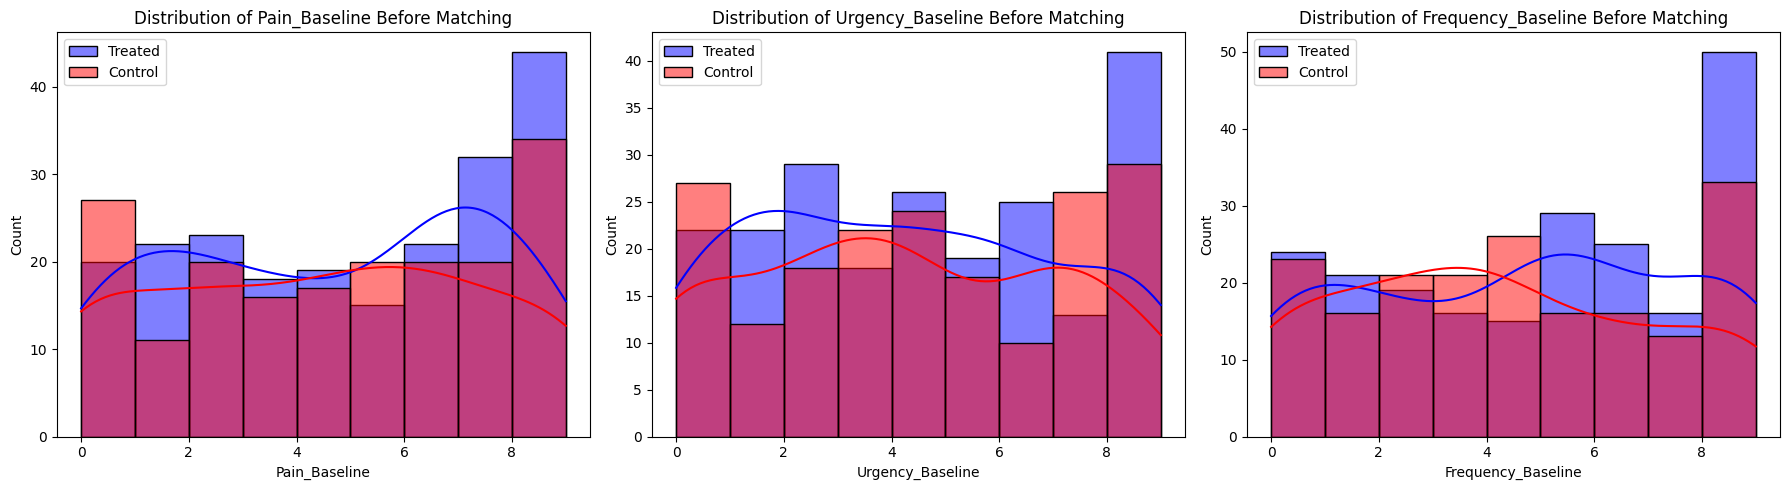

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features_to_check = ['Pain_Baseline', 'Urgency_Baseline', 'Frequency_Baseline']

for i, feature in enumerate(features_to_check):
    sns.histplot(treated[feature], color='blue', label='Treated', kde=True, ax=axes[i])
    sns.histplot(untreated[feature], color='red', label='Control', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} Before Matching')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Sensitivity Analysis

We evaluate whether hidden biases could explain observed treatment effects.

In [58]:
# Compute Mahalanobis distance before and after matching
data['Mahalanobis_Before'] = data.apply(lambda row: mahalanobis_distance(row[features].values, data[features].mean().values, cov_inv), axis=1)
matched_treated = data.loc[data['ID'].isin(matched_pairs['Treated_ID'])].copy()
matched_control = data.loc[data['ID'].isin(matched_pairs['Control_ID'])].copy()

matched_treated['Mahalanobis_After'] = matched_treated.apply(lambda row: mahalanobis_distance(row[features].values, matched_control[features].mean().values, cov_inv), axis=1)
matched_control['Mahalanobis_After'] = matched_control.apply(lambda row: mahalanobis_distance(row[features].values, matched_treated[features].mean().values, cov_inv), axis=1)

## Outcome Analysis
Use boxplots to compare Pain, Urgency, and Frequency scores across different time points.

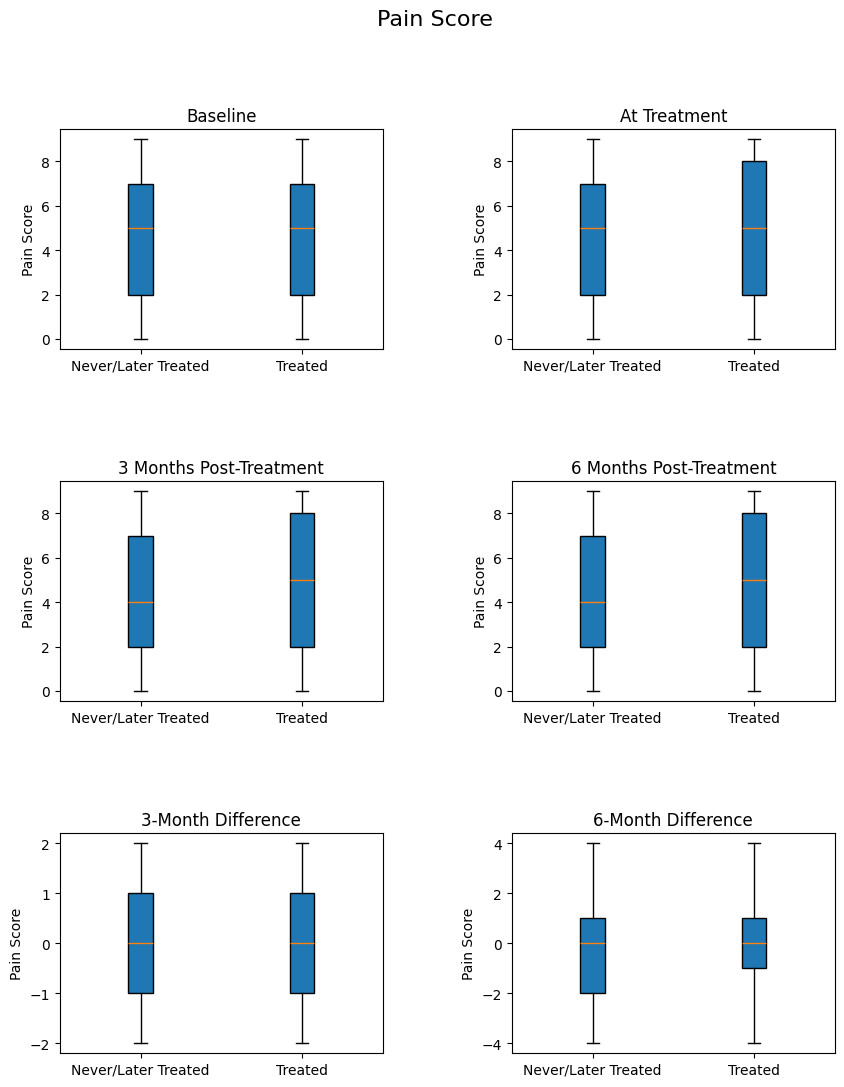

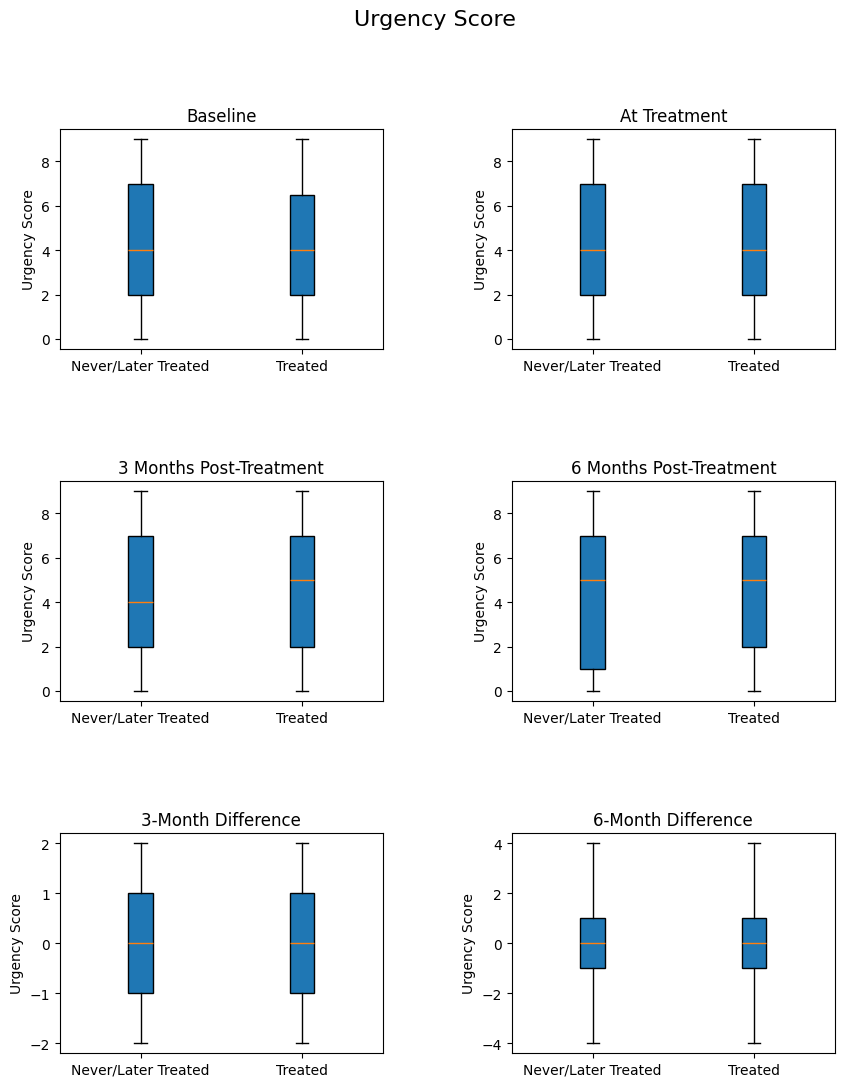

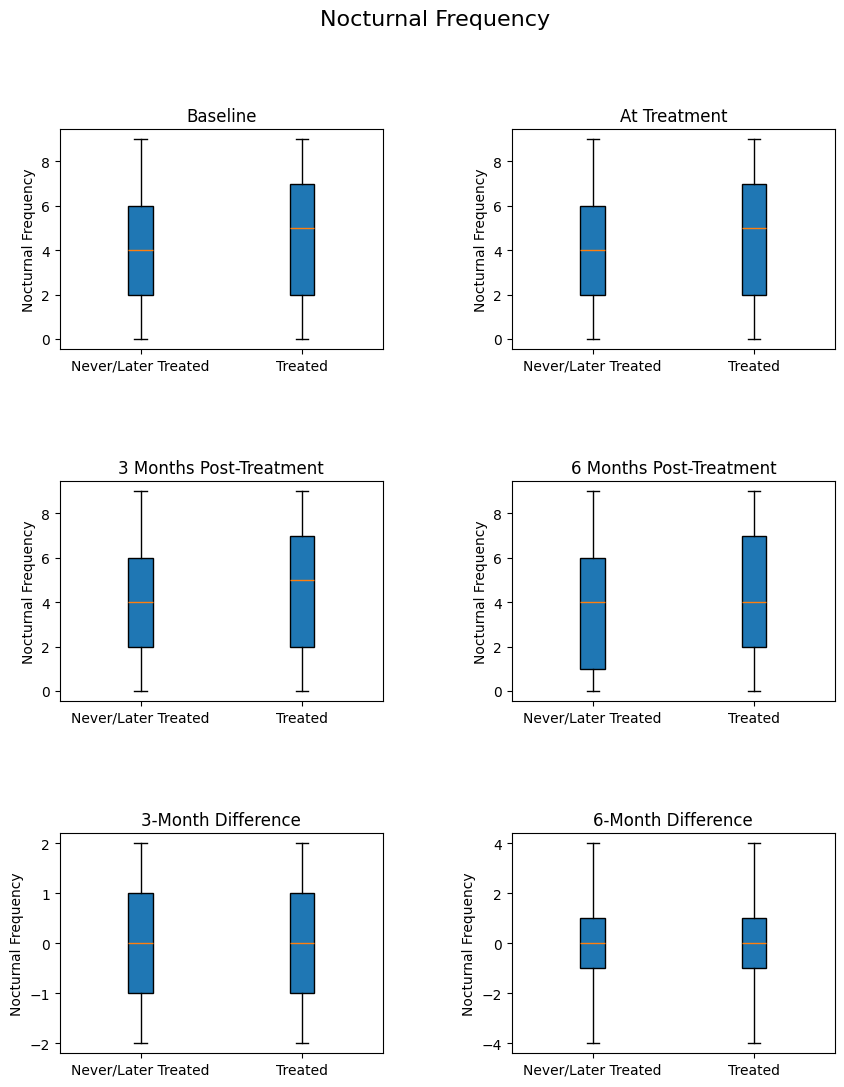

In [61]:
def generate_boxplots(variable, label):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
    fig.suptitle(label, fontsize=16)
    
    plot_titles = ["Baseline", "At Treatment", "3 Months Post-Treatment",
                   "6 Months Post-Treatment", "3-Month Difference", "6-Month Difference"]
    
    data[f"{variable}_Diff_3M"] = data[f"{variable}_3_Months"] - data[f"{variable}_Treatment"]
    data[f"{variable}_Diff_6M"] = data[f"{variable}_6_Months"] - data[f"{variable}_Treatment"]
    
    timeframes = [f"{variable}_Baseline", f"{variable}_Treatment", f"{variable}_3_Months",
                  f"{variable}_6_Months", f"{variable}_Diff_3M", f"{variable}_Diff_6M"]
    
    for index, timeframe in enumerate(timeframes):
        r, c = divmod(index, 2)
        group_1 = data.loc[data['Treated'] == 0, timeframe]
        group_2 = data.loc[data['Treated'] == 1, timeframe]
        
        axes[r, c].boxplot([group_1, group_2], tick_labels=["Never/Later Treated", "Treated"], patch_artist=True)
        axes[r, c].set_title(plot_titles[index])
        axes[r, c].set_ylabel(label)
    
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.show()

generate_boxplots("Pain", "Pain Score")
generate_boxplots("Urgency", "Urgency Score")
generate_boxplots("Frequency", "Nocturnal Frequency")